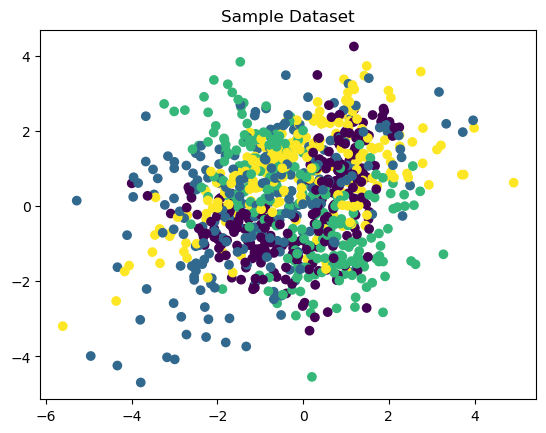

IndexError: index 3 is out of bounds for axis 0 with size 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Random Forest Implementation
class RandomForest:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=2, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth, 
                                min_samples_split=self.min_samples_split,
                                max_features=self.max_features)
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        # For classification: majority voting
        predictions = [Counter(tree_predictions[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]
        return np.array(predictions)

# Decision Tree Implementation
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.max_features else self.max_features
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if (depth >= self.max_depth or n_samples < self.min_samples_split or len(set(y)) == 1):
            return self._most_common_label(y)

        feature_indices = np.random.choice(n_features, self.n_features, replace=False)

        best_feat, best_thresh = self._best_split(X, y, feature_indices)
        if best_feat is None:
            return self._most_common_label(y)

        left_indices = X[:, best_feat] <= best_thresh
        right_indices = X[:, best_feat] > best_thresh

        left_child = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return {"feature": best_feat, "threshold": best_thresh, "left": left_child, "right": right_child}

    def _best_split(self, X, y, feature_indices):
        best_gain = -1
        split_index, split_threshold = None, None
        for feat_idx in feature_indices:
            thresholds = np.unique(X[:, feat_idx])
            for thresh in thresholds:
                gain = self._information_gain(y, X[:, feat_idx], thresh)
                if gain > best_gain:
                    best_gain = gain
                    split_index = feat_idx
                    split_threshold = thresh
        return split_index, split_threshold

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y)
        left_indices = X_column <= split_thresh
        right_indices = X_column > split_thresh

        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        n, n_left, n_right = len(y), sum(left_indices), sum(right_indices)
        e_left, e_right = self._entropy(y[left_indices]), self._entropy(y[right_indices])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        return parent_entropy - child_entropy

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        return Counter(y).most_common(1)[0][0]

    def _traverse_tree(self, x, tree):
        if isinstance(tree, dict):
            if x[tree["feature"]] <= tree["threshold"]:
                return self._traverse_tree(x, tree["left"])
            return self._traverse_tree(x, tree["right"])
        return tree

# Example Dataset
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=100, n_features=3, n_classes=2, random_state=42)
X, y = make_classification(
    n_samples=1000,        # Number of samples
    n_features=4,         # Total number of features
    n_informative=4,      # Number of informative features
    n_redundant=0,        # Number of redundant features
    n_repeated=0,         # Number of repeated features
    n_classes=4,          # Number of output classes
    random_state=42       # Ensures reproducibility
)

# Visualize Dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.title("Sample Dataset")
plt.show()

# Train Random Forest
rf = RandomForest(n_trees=5, max_depth=10, min_samples_split=2)
rf.fit(X, y)

# Predict
y_pred = rf.predict(X)

# Visualize Decision Boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array(Z).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap="viridis")
    plt.title("Random Forest Decision Boundary")
    plt.show()

plot_decision_boundary(rf, X, y)
